### Análisis Exploratorio de 40K-Palms
Este conjunto de datos fue construido a partir del 11k-hands de A.E. presentado en [aaa]. 11k-hands contiene imágenes en primer plano de manos con un fondo relativamente uniforme. En un primer paso se seleccionaron sólo las imágenes que correspondían a 5395 imágenes de palmas. Para encontrar la máscara de segmentación, estas imágenes fueron preprocesadas usando la implementación del algoritmo GrabCut [aaa] de la librería OpenCV [aaa], este proceso fue realizado de forma manual [url de video], luego del cual se obtuvieron 5388 imágenes de palmas con sus respectivas máscaras de segmentación. A partir de estas imágenes se construye el conjunto de datos final, para lo cual se usa la técnica de aumentación de datos mediante una matriz de transformación aleatoria (traslación, rotación, escalamiento), se obtienen fondos aleatorios del conjunto de datos OpenImages [aaa] y estos son combinados con las imágenes originales.

#### Conjunto de Datos

In [2]:
import os

# directorios del conjuntos de datos (palmas y máscaras)
img_dir = "/Datasets/5k-palms/40k-jpg-256x256/"
label_dir = "/Datasets/5k-palms/40k-masks-mono-256x256/"

# leemos el conjunto de datos de la lista de todos los archivos
img_files = [img_dir + f for f in os.listdir(img_dir)]
label_files = [label_dir + f for f in os.listdir(label_dir)]
# la lista devuelta por listdir está en orden aleatorio
img_files.sort()
label_files.sort()

In [3]:
from sklearn.model_selection import train_test_split

# generamos el conjunto de datos de prueba, el de validación y el de entrenamiento
x_test_filenames, img_files_after_test, y_test_filenames, label_files_after_test = \
        train_test_split(img_files, label_files, test_size=0.1, random_state=42)

x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
        train_test_split(img_files_after_test, label_files_after_test, test_size=0.2, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 3448
Number of validation examples: 863


In [4]:
print(x_train_filenames[:1], y_train_filenames[:1])

['/Datasets/5k-palms/40k-jpg-256x256/Hand_0009039.jpg.2.jpg'] ['/Datasets/5k-palms/40k-masks-mono-256x256/Hand_0009039.jpg.2.png']


#### Visualización

In [6]:
# for reading jpg images
!pip install Pillow

    100% |████████████████████████████████| 2.0MB 556kB/s ta 0:00:01
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


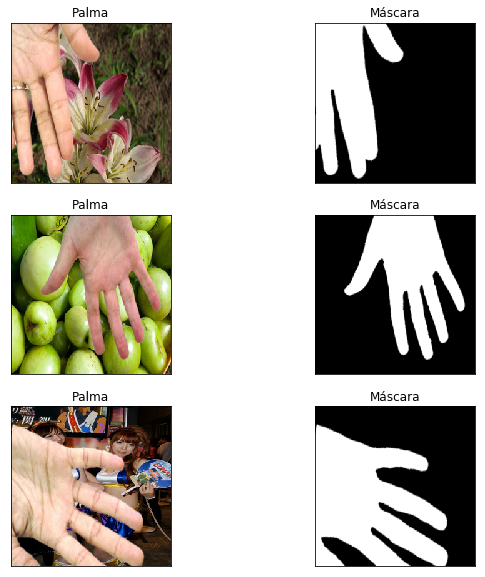

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

%matplotlib inline

display_num = 3

np.random.seed(4242)
r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 10))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(image.imread(x_pathname))
    plt.title("Palma")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(image.imread(y_pathname), cmap='gray')
    plt.title("Máscara")  
    plt.xticks([])
    plt.yticks([])

plt.show()

#### Dataset en TF

In [5]:
import _40k_dataset
import importlib
importlib.reload(_40k_dataset)  # hot-reload
from _40k_dataset import _augment, get_baseline_dataset

import functools

# definición de constantes 
img_shape = (256, 256, 3)  # debe ser divisible por 32 (maxpool2d)
batch_size = 8

# construcción de dataset
tr_cfg = {
    # 'resize': [img_shape[0], img_shape[1]],  # dataset ya tiene tamaño de entrada del modelo
    'scale': 1 / 255.
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)

val_cfg = {
    # 'resize': [img_shape[0], img_shape[1]],  # dataset ya tiene tamaño de entrada del modelo
    'scale': 1 / 255.
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

#### Construyendo el modelo
A partir del modelo propuesto en https://arxiv.org/abs/1505.04597, modelo codificador-decodificador.

In [6]:
import _40k_model
import importlib
importlib.reload(_40k_model)  # hot-reload
from _40k_model import encoder_block, decoder_block, conv_block, bce_dice_loss, dice_loss

from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import losses

inputs = layers.Input(shape=img_shape)
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 1024)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

model = models.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

#### Métricas de pérdida 
- Dice loss: measures overlap http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf
- Binary cross entropy 

### 100 epochs with 3.5k images

In [7]:
import tensorflow as tf
import numpy as np

epochs = 100
save_model_path = '/Datasets/5k-palms/40k-weights-100ep-3.5k.hdf5'

cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [8]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Epoch 1/100
431/431 [==============================] - 282s 655ms/step - loss: 0.2773 - dice_loss: 0.1218 - val_loss: 0.2647 - val_dice_loss: 0.1216

Epoch 00001: val_dice_loss improved from inf to 0.12165, saving model to /Datasets/5k-palms/40k-weights.hdf5
Epoch 2/100
431/431 [==============================] - 271s 628ms/step - loss: 0.1867 - dice_loss: 0.0778 - val_loss: 0.1718 - val_dice_loss: 0.0652

Epoch 00002: val_dice_loss improved from 0.12165 to 0.06522, saving model to /Datasets/5k-palms/40k-weights.hdf5
Epoch 3/100
431/431 [==============================] - 271s 628ms/step - loss: 0.1559 - dice_loss: 0.0642 - val_loss: 0.1484 - val_dice_loss: 0.0607

Epoch 00003: val_dice_loss improved from 0.06522 to 0.06070, saving model to /Datasets/5k-palms/40k-weights.hdf5
Epoch 4/100
431/431 [==============================] - 271s 628ms/step - loss: 0.1303 - dice_loss: 0.0532 - val_loss: 2.4097 - val_dice_loss: 0.8305

Epoch 00004: val_dice_loss did not improve from 0.06070
Epoch 5/1

431/431 [==============================] - 271s 628ms/step - loss: 0.0259 - dice_loss: 0.0117 - val_loss: 0.0268 - val_dice_loss: 0.0118

Epoch 00073: val_dice_loss improved from 0.01182 to 0.01179, saving model to /Datasets/5k-palms/40k-weights.hdf5
Epoch 74/100
431/431 [==============================] - 271s 628ms/step - loss: 0.0258 - dice_loss: 0.0116 - val_loss: 0.0267 - val_dice_loss: 0.0117

Epoch 00074: val_dice_loss improved from 0.01179 to 0.01172, saving model to /Datasets/5k-palms/40k-weights.hdf5
Epoch 75/100
431/431 [==============================] - 271s 628ms/step - loss: 0.0257 - dice_loss: 0.0116 - val_loss: 0.0267 - val_dice_loss: 0.0117

Epoch 00075: val_dice_loss did not improve from 0.01172
Epoch 76/100
431/431 [==============================] - 271s 628ms/step - loss: 0.0257 - dice_loss: 0.0116 - val_loss: 0.0267 - val_dice_loss: 0.0117

Epoch 00076: val_dice_loss did not improve from 0.01172
Epoch 77/100
431/431 [==============================] - 271s 628ms/step

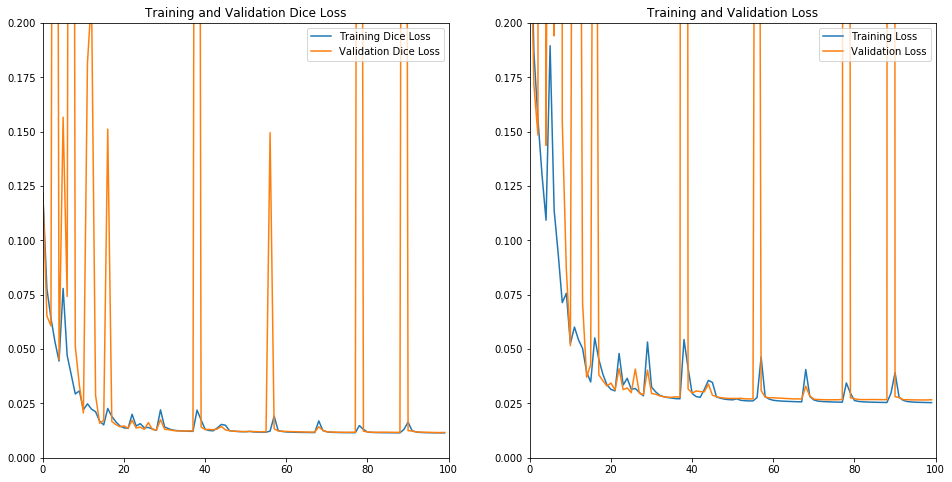

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

dice = history.history['dice_loss'][:]
val_dice = history.history['val_dice_loss'][:]

loss = history.history['loss'][:]
val_loss = history.history['val_loss'][:]

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')
plt.ylim((0,0.2))
plt.xlim((0,100))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim((0,0.2))
plt.xlim((0,100))

plt.show()

In [29]:
test_cfg = {
    'scale': 1 / 255.
}
test_preprocessing_fn = functools.partial(_augment, **test_cfg)
test_ds = get_baseline_dataset(x_test_filenames,
                              y_test_filenames, 
                              preproc_fn=test_preprocessing_fn,
                              batch_size=batch_size)

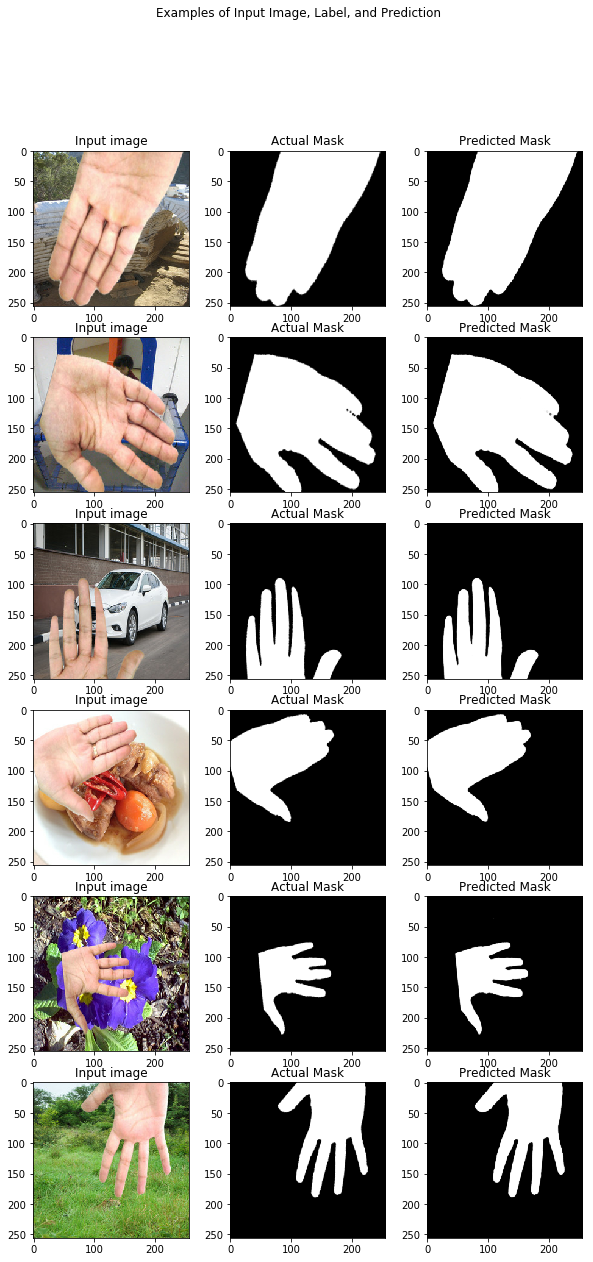

In [33]:
# Let's visualize some of the outputs 
data_aug_iter = test_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
num_imgs = 6
for i in range(num_imgs):
    batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
    img = batch_of_imgs[0]
    predicted_label = model.predict(batch_of_imgs)[0]

    plt.subplot(num_imgs, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(num_imgs, 3, 3 * i + 2)
    plt.imshow(label[0, :, :, 0], cmap='gray')
    plt.title("Actual Mask")
    plt.subplot(num_imgs, 3, 3 * i + 3)
    plt.imshow(predicted_label[:, :, 0], cmap='gray')
    plt.title("Predicted Mask")
    
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

In [27]:
save_model_path = '/Datasets/5k-palms/40k-weights-100ep-3.5k'
model.save_weights(save_model_path)
model.save(save_model_path + '.h5')
print(save_model_path + " saved")

/Datasets/5k-palms/40k-weights-100ep-3.5k saved


### 5 epochs with 35k images

In [19]:
epochs = 100
save_model_path = '/Datasets/5k-palms/40k-final-weights.h5'
model.save_weights('/Datasets/5k-palms/40k-final-weights')
model.save(save_model_path)

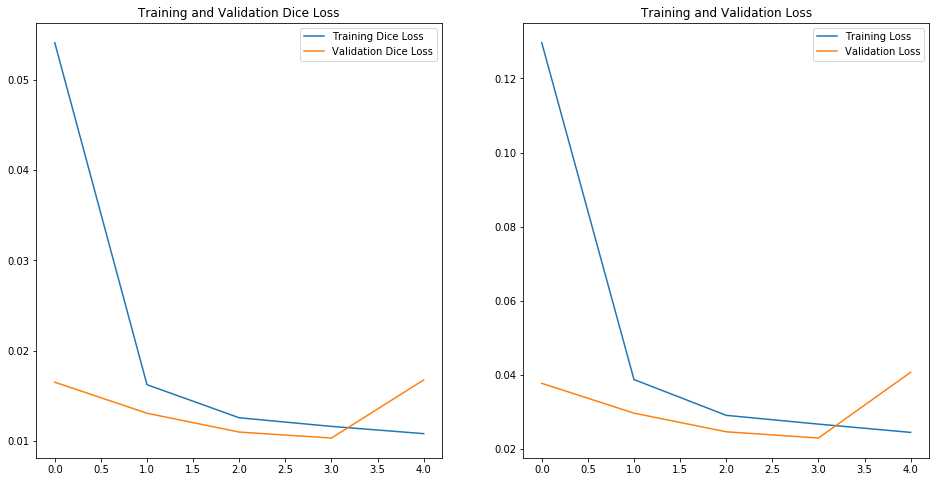

In [20]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [5]:
from tensorflow.python.keras import models

# Alternatively, load the weights directly: model.load_weights(save_model_path)
save_model_path = '/Datasets/5k-palms/40k-final-weights.h5'
model = models.load_model(save_model_path, 
        custom_objects={
            'bce_dice_loss': bce_dice_loss,
            'dice_loss': dice_loss})

NameError: name 'losses' is not defined

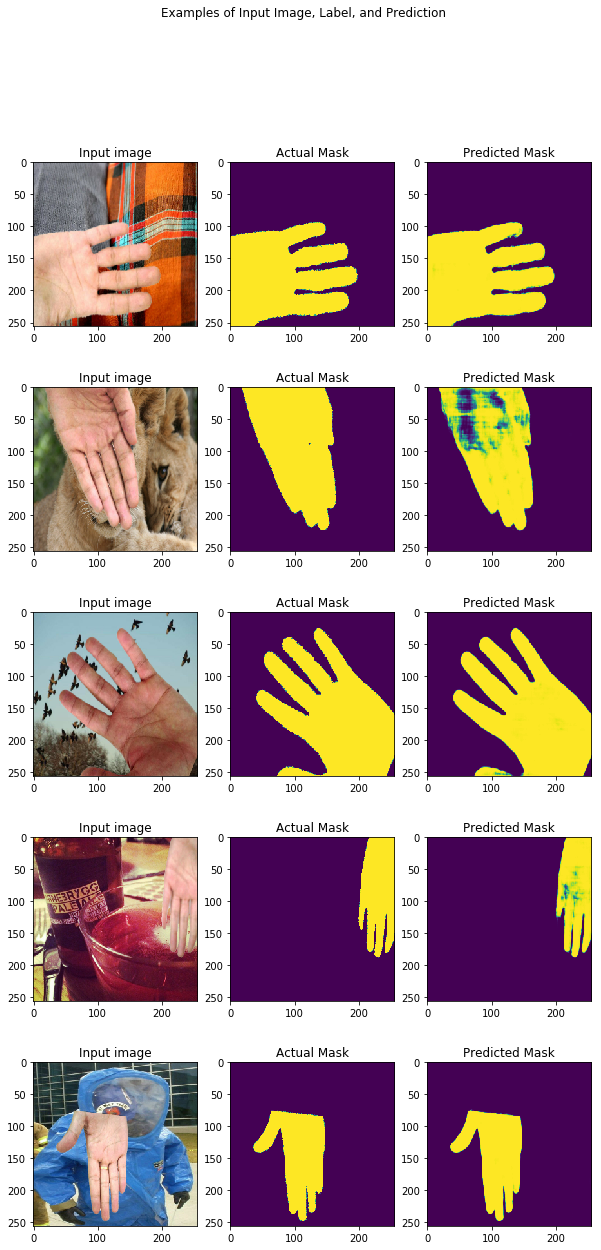

In [21]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
    img = batch_of_imgs[0]
    predicted_label = model.predict(batch_of_imgs)[0]

    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(label[0, :, :, 0], cmap='gray')
    plt.title("Actual Mask")
    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(predicted_label[:, :, 0], cmap='gray')
    plt.title("Predicted Mask")
    
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()